In [57]:
import numpy as np
from numpy import abs, sqrt, log10, sin, cos, exp, cosh, tanh, log, conj, cosh, sinh
np.set_printoptions(precision=16)
from math import pi, factorial
from numpy.random import rand
from numpy.linalg import norm
import scipy
import scipy.sparse as sp
from scipy.sparse import linalg, csc_matrix
import time
from scipy.optimize import minimize
from scipy.special import eval_hermite

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
#mpl.rcParams["figure.dpi"] = 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import pickle

from qonn_cobyla import *

from qutip import *

import matplotlib as mpl

from matplotlib import cm

from scipy.signal import argrelextrema, find_peaks, savgol_filter
from scipy.optimize import curve_fit

In [58]:
def QFI(psi):
    '''
    This function computes the quantum Fisher information of the pure state psi.
    '''
    
    # Encoding (MZ interferometer)
    psi_phi = oc.eval_rho_interf(phi, psi)
    psi_delta = oc.eval_rho_interf(phi_delta, psi)

    # Evaluate QFI
    F = np.abs(psi_phi[np.newaxis, :].conj() @ psi_delta[:, np.newaxis])
    cost = (8*(1-F)/oc.delta**2)[0][0]

    return cost

In [59]:
def get_rho(psi):
    '''
    This function computes the density matrix of the first mode (by tracing out the emitters and the second mode).
    Input: total pure state psi.
    '''

    # We trace out the emitters
    rho = psi[:, np.newaxis] @ psi[np.newaxis, :].conj()
    basis_c = csc_matrix(np.eye((N_p+1)**2, dtype=np.complex128))
    basis_e = csc_matrix(np.eye(2**2, dtype=np.complex128))
    rho_c = 0 # Initialize reduced density matrix of mode 1
    for j in range(2**2):
        rho_c += sp.kron(basis_e[:, j].H, basis_c) @ rho @ sp.kron(basis_e[:, j], basis_c)

    # We trace out the second mode
    basis_1 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    basis_2 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    rho_1 = 0 # Initialize reduced density matrix of mode 1
    for j in range(N_p+1):
        rho_1 += sp.kron(basis_2[:, j].H, basis_1) @ rho_c @ sp.kron(basis_2[:, j], basis_1)

    return rho_1

In [60]:
def QFI_explicit(psi):
    '''
    This function calculates the QFI of the pure state psi.
    '''

    psi_phi = np.copy(psi)
    # Encoding (MZ interferometer)
    psi_phi = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d, dtype=np.complex128) + setup.H_BS_sym_ec()), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * (phi[1] * setup.H_phi_ec() ), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d, dtype=np.complex128) + setup.H_BS_sym_ec()), psi_phi)
    
    psi_delta = np.copy(psi)
    # Encoding (MZ interferometer)
    psi_delta = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d, dtype=np.complex128) + setup.H_BS_sym_ec()), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * (phi_delta[1] * setup.H_phi_ec() ), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d, dtype=np.complex128) + setup.H_BS_sym_ec()), psi_delta)

    # Evaluate QFI
    F = np.abs(psi_phi[np.newaxis, :].conj() @ psi_delta[:, np.newaxis])
    cost = (8*(1-F)/oc.delta**2)[0][0]

    return cost

In [61]:
def get_wigner(psi):
    '''
    This function gets the Wigner quasiprobability distribution of the pure state psi (in QuTiP).
    '''

    # We trace out the emitters
    rho = psi[:, np.newaxis] @ psi[np.newaxis, :].conj()
    basis_c = csc_matrix(np.eye((N_p+1)**2, dtype=np.complex128))
    basis_e = csc_matrix(np.eye(2**2, dtype=np.complex128))
    rho_c = 0 # Initialize reduced density matrix of mode 1
    for j in range(2**2):
        rho_c += sp.kron(basis_e[:, j].H, basis_c) @ rho @ sp.kron(basis_e[:, j], basis_c)

    # We trace out the second mode
    basis_1 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    basis_2 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    rho_1 = 0 # Initialize reduced density matrix of mode 1
    for j in range(N_p+1):
        rho_1 += sp.kron(basis_2[:, j].H, basis_1) @ rho_c @ sp.kron(basis_2[:, j], basis_1)

    rho_1_qutip = Qobj(rho_1)
    xvec = np.linspace(-sqrt(N_p), sqrt(N_p), 200)
    W_1 = wigner(rho_1_qutip, xvec, xvec)

    return W_1

In [62]:
N_e = 2
N_c = 2
d = 2
layers_p = d
layers_m = d

phi = [0, pi/3, 0]
delta = 1e-2
phi_delta = [0, pi/3 + delta, 0]

Fit exponent = -0.11863295015689027
Fit exponent = -0.3061326857264204


[Text(4, 0, '$4$'), Text(10, 0, '$10$'), Text(40, 0, '$40$')]

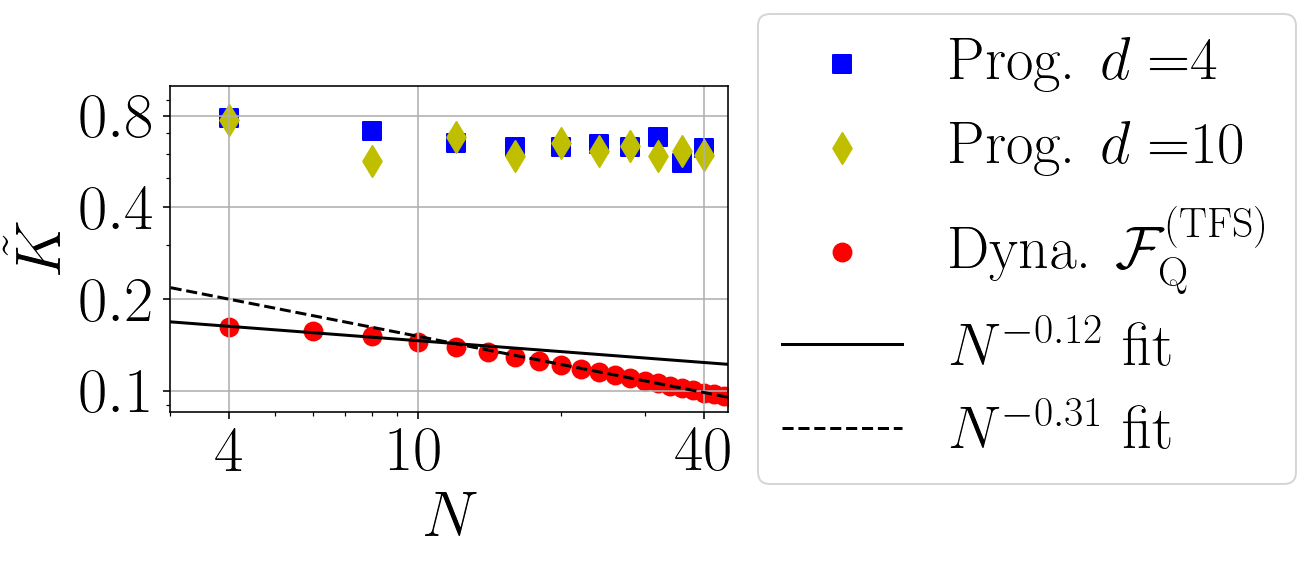

In [63]:
# We plot the results
plt.rcParams["figure.figsize"] = [5, 3]
fig, ax = plt.subplots(1, 1)
marker_size = 80
fs = 32
ax.grid()

#############################################################
# Sum of the optimal interactions in the programmable setup #
#############################################################

d = 4 # Number of layers
seeds = np.arange(1, 41, 1)
name = 'seed_kerr_res_asaf_d_uptoN'

N_p_list = np.arange(8, 88, 8)
params_p_list = []

for i_N, N_p in enumerate(N_p_list):

    cost_p_matrix = []

    for seed in seeds:

        with open('G:\Mi unidad\Efficient state generation for metrology\Paper v1\Figure 9\Kerr photon counting data\cost_p_'+name+'_Np={}_seed={}.p'.format(int(N_p), seed), 'rb') as fp:
            input = pickle.load(fp)
            cost_p_matrix.append(input[d-1])

    index_p_min = np.argmin(cost_p_matrix)

    with open('G:\Mi unidad\Efficient state generation for metrology\Paper v1\Figure 9\Kerr photon counting data\params_p_'+name+'_Np={}_seed={}.p'.format(int(N_p), index_p_min+1), 'rb') as fp:
        input = pickle.load(fp)
        params_p_list.append(input[d-1])

Js_k_p = np.zeros((len(N_p_list), d))
Us_p = np.zeros((len(N_p_list), d))

for i_N, N_p in enumerate(N_p_list):

    j0 = 0
    j1 = 0

    for i in range(2*d):

        if i % 2 == 0:
            Js_k_p[i_N, j0] = params_p_list[i_N][i]
            j0 += 1

        if i % 2 == 1:
            Us_p[i_N, j1] = params_p_list[i_N][i]
            j1 += 1

sum = 0
for i in range(d):
    sum += abs(Us_p[:, i])

ax.scatter(np.array(N_p_list)/2, sum, color='blue', s=marker_size, marker='s', label=r'Prog. $d=$'+'{:}'.format(int(d)))

#############################################################
# Sum of the optimal interactions in the programmable setup #
#############################################################

d = 10 # Number of layers
seeds = np.arange(1, 41, 1)
name = 'seed_kerr_res_asaf_d_uptoN'

N_p_list = np.arange(8, 88, 8)
params_p_list = []

for i_N, N_p in enumerate(N_p_list):

    cost_p_matrix = []

    for seed in seeds:

        with open('G:\Mi unidad\Efficient state generation for metrology\Paper v1\Figure 9\Kerr photon counting data\cost_p_'+name+'_Np={}_seed={}.p'.format(int(N_p), seed), 'rb') as fp:
            input = pickle.load(fp)
            cost_p_matrix.append(input[d-1])

    index_p_min = np.argmin(cost_p_matrix)

    with open('G:\Mi unidad\Efficient state generation for metrology\Paper v1\Figure 9\Kerr photon counting data\params_p_'+name+'_Np={}_seed={}.p'.format(int(N_p), index_p_min+1), 'rb') as fp:
        input = pickle.load(fp)
        params_p_list.append(input[d-1])

Js_k_p = np.zeros((len(N_p_list), d))
Us_p = np.zeros((len(N_p_list), d))

for i_N, N_p in enumerate(N_p_list):

    j0 = 0
    j1 = 0

    for i in range(2*d):

        if i % 2 == 0:
            Js_k_p[i_N, j0] = params_p_list[i_N][i]
            j0 += 1

        if i % 2 == 1:
            Us_p[i_N, j1] = params_p_list[i_N][i]
            j1 += 1

sum = 0
for i in range(d):
    sum += abs(Us_p[:, i])

ax.scatter(np.array(N_p_list)/2, sum, color='y', s=1.5*marker_size, marker='d', label=r'Prog. $d=$'+'{:}'.format(int(d)))

##########################################
# Time of first estimation error minimum #
##########################################

k = 2
with open('QFI_uptoN_k={:}.p'.format(int(k)), 'rb') as file: 
    input = pickle.load(file) 
N_list = input[0]
t_vec = input[1]
QFI_matrix = input[2]
Dphi = 1/QFI_matrix

indices_matrix = []
for i_N, N_p in enumerate(N_list[1:]):
    N = N_p/2
    indices = [i for i, x in enumerate(Dphi[i_N+1]) if x < 2/(N*(N+2))]
    indices_matrix.append(indices[0])

N_list = N_list / 2

ax.scatter(N_list[1:], t_vec[indices_matrix], marker_size, color='red', label=r'Dyna. $\mathcal{F}^{\rm (TFS)}_{\rm Q}$')

x = log10(N_list[1:5])
y = log10(t_vec[indices_matrix][:4])
p = np.polyfit(x, y, 1)
x_fit = np.linspace(0.09, 2, 100)
y_fit = p[0]*x_fit + p[1]
ax.plot(10**x_fit, 10**y_fit, '-k', label=r'$N^{{{:.2f}}}$ fit'.format(p[0]))
print('Fit exponent = {:}'.format(p[0]))

x = log10(N_list[11:])
y = log10(t_vec[indices_matrix][10:])
p = np.polyfit(x, y, 1)
x_fit = np.linspace(0.09, 2, 100)
y_fit = p[0]*x_fit + p[1]
ax.plot(10**x_fit, 10**y_fit, '--k', label=r'$N^{{{:.2f}}}$ fit'.format(p[0]))
print('Fit exponent = {:}'.format(p[0]))

########################
# We format the figure #
########################



#ax.set_title('Kerr', fontsize=fs)
ax.set_ylabel(r'$\tilde{K}$', fontsize=fs)
ax.set_xlabel(r'$N$', fontsize=fs)
ax.tick_params(axis='both', labelsize=fs)



ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs-2)

ax.set_yscale('log')
ax.set_ylim(8.5e-2, 1)
ax.set_yticks([0.1, 0.2, 0.4, 0.8])
ax.set_yticklabels([r'$0.1$', r'$0.2$', r'$0.4$', r'$0.8$'])

ax.set_xscale('log')
ax.set_xlim(3, 45)
ax.set_xticks([4, 10, 40])
ax.set_xticklabels([r'$4$', r'$10$', r'$40$'])

#plt.savefig('Figure 10 v2 output.svg', bbox_inches='tight', dpi=600)